In [29]:
import itertools
import os
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from PIL import Image
from scipy import signal
from skimage import (
    filters,
    segmentation,
    )
from sklearn.preprocessing import StandardScaler

In [30]:
def average_of_neighborhood(img, size=4):
    """"""
    img_avg = np.zeros(img.shape)
    for idx, v in np.ndenumerate(img):
        x, y = idx
        x0 = x - size
        if x0 < 0:
            continue
        y0 = y - size
        if y0 < 0:
            continue
        x1 = x + size
        if x1 > (img.shape[0] - 1):
            continue
        y1 = y + size
        if y1 > (img.shape[1] - 1):
            continue
        neighbors = img[x0-size:x0+size, y0-size:y0+size]
        img_avg[x, y] = np.average(neighbors)
    return img_avg

## Visualize Original and Gaussian Filtered Images

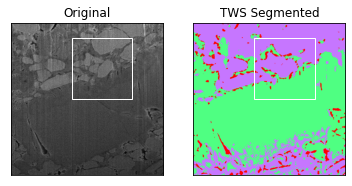

In [31]:
img = plt.imread("unsegmented/000.tif")
img_tws = plt.imread("segmented/000.tif")
img_tws2 = np.asarray(Image.open("segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((200, 50), 200, 200, edgecolor='w', fill=False)
rect1 = patches.Rectangle((200, 50), 200, 200, edgecolor='w', fill=False)
ax[0].add_patch(rect0)
ax[0].set_title("Original")
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].set_title("TWS Segmented")
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
plt.savefig("tws-segmented-results.png", dpi=500, pad_inches=0)
plt.show()

The top left corner of the white rectangle section of TWS segmented image should be green to indicate electrolyte phase.
Overall, the sections highlighted in white show that the segmentation deems active material particles to be fused when they are not fused in the original image. This fusion underestimates specific active material area.

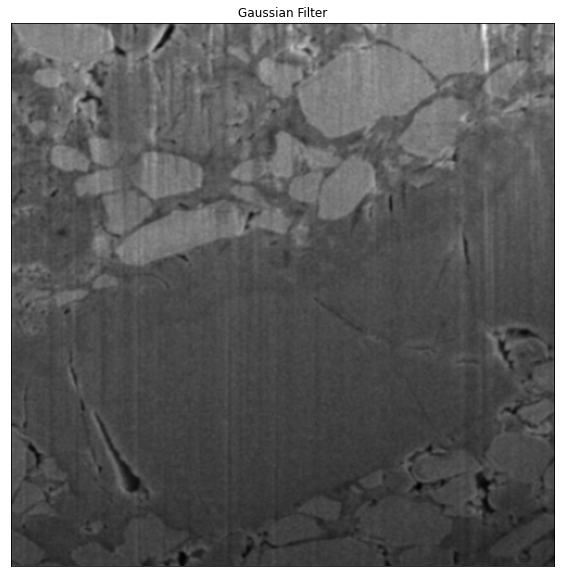

In [32]:
img_gauss = filters.gaussian(img)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gauss, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Gaussian Filter")

plt.show()

### FFT Band Pass Filter

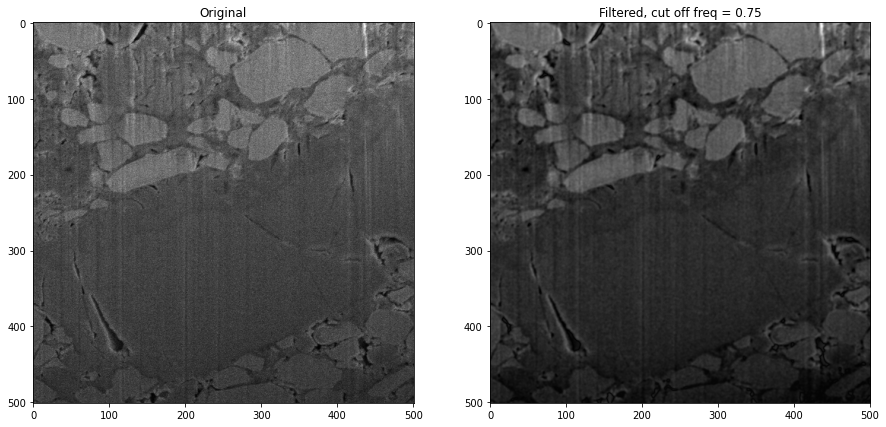

In [33]:
def H_lo(D, D0, n):
    return 1 / (1 + (D/D0) ** (2 * n))


def H_hi(D, D0, n):
    return 1 / (1 + (D0/D) ** (2 * n))

F = np.fft.fft2(img_gauss)
Fshift = np.fft.fftshift(F)
M, N = img.shape
H = np.zeros((M, N), dtype=np.float32)
n = 1
D0 = 0.75

for u in range(M):
    for v in range(N):
        D = np.sqrt((u - M/2) ** 2 + (v - N/2) ** 2)
        H[u, v] = H_hi(D, D0, n)

Gshift = Fshift * H
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(g, cmap="gray")
ax[1].set_title(f"Filtered, cut off freq = {D0}")
plt.imsave("fft-hi-unsegmented.bmp", g, cmap='gray', format="bmp")
plt.show()

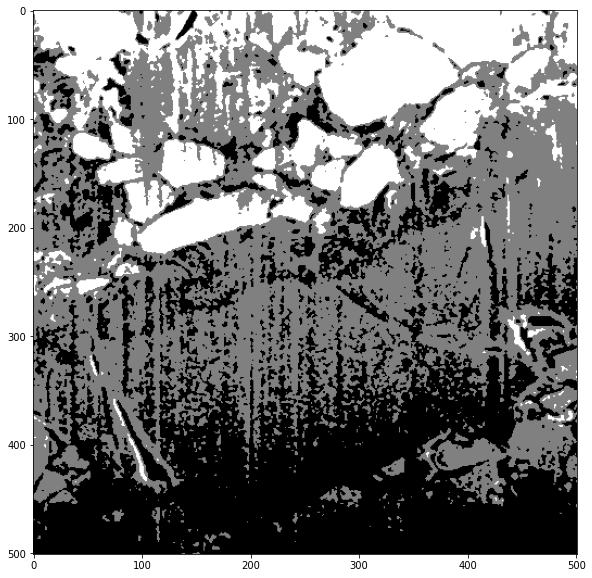

In [34]:
thresholds = filters.threshold_multiotsu(g)
img_seg = np.digitize(g, bins=thresholds)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_seg, cmap='gray')
plt.show()

## Segmentation via Edge Detection
We could try different thresholds with the Meijering filter and then identify clusters for each threshold. For each threshold, we calculate the pixel average per cluster. The best threshold is the on that minimizes the variance of the pixel average per cluster<br/>
### Meijering Filter

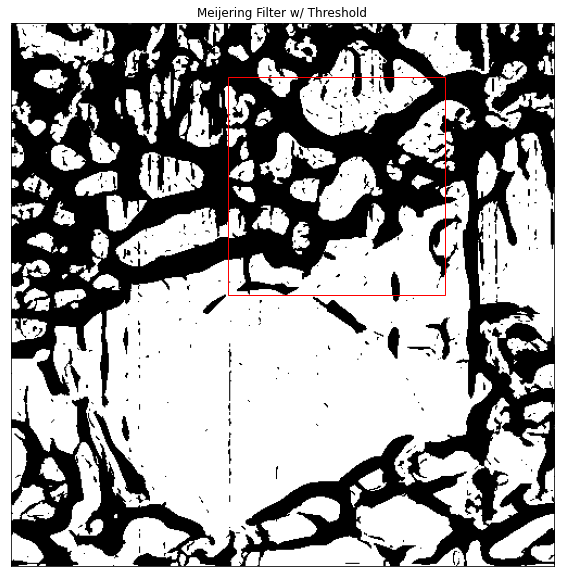

In [35]:
img_meijer = filters.meijering(g) < 0.1
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_meijer, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Meijering Filter w/ Threshold")
rect = patches.Rectangle((200, 50), 200, 200, edgecolor='r', fill=False)
ax.add_patch(rect)
plt.savefig("img-meijer-threshold.png", dpi=500)
plt.show()

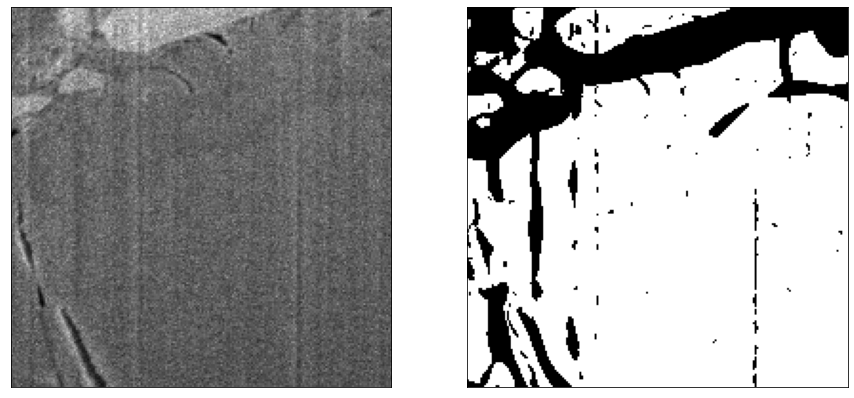

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img[200:400, 50:250], cmap='gray')
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

ax[1].imshow(img_meijer[200:400, 50:250], cmap='gray')
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)

plt.show()

### Identification of Clusters

In [37]:
points = set()
for (x, y) in np.argwhere(img_meijer):
    points.add((x, y))
point_ids = np.zeros((len(points), 2))
for idx, point in enumerate(points):
    point_ids[idx, :] = point
points_view = {(v[0], int(v[1])): k for k, v in enumerate(point_ids)}

G = nx.Graph()
for k, v in points_view.items():
    G.add_node(v)
for k in points_view.keys():
    x, y = k
    neighbors = [
        (int(x + 1), y),
        (int(x - 1), y),
        (x, int(y + 1)),
        (x, int(y - 1)),
    ]
    p0 = points_view[k]
    for neighbor in neighbors:
        p = points_view.get(neighbor)
        if p is None:
            continue
        G.add_edge(p0, p)
pieces = nx.connected_components(G)
pieces = [piece for piece in pieces]

### Average of pixel values per connected pixels cluster

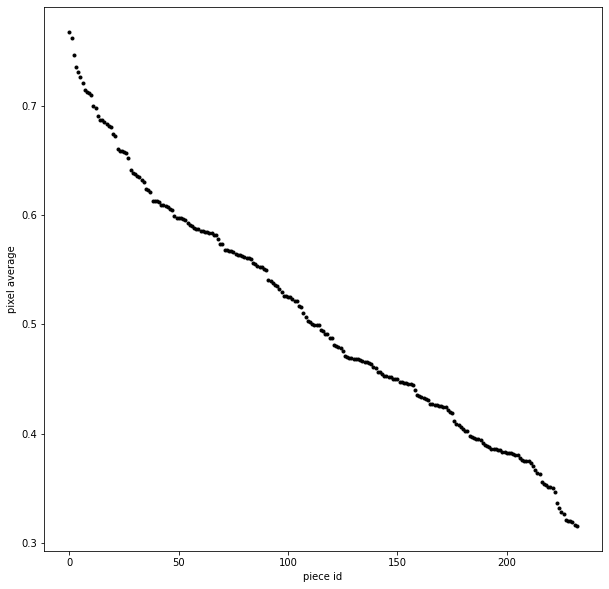

In [38]:
pixel_average = np.zeros(len(pieces)).reshape(-1, 1)
for idx, piece in enumerate(pieces):
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    pixel_average[idx] = np.average(img_meijer[piece_points])

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(pieces)), sorted(pixel_average.tolist(), reverse=True), '.k')
ax.set_xlabel("piece id")
ax.set_ylabel("pixel average")
plt.show()

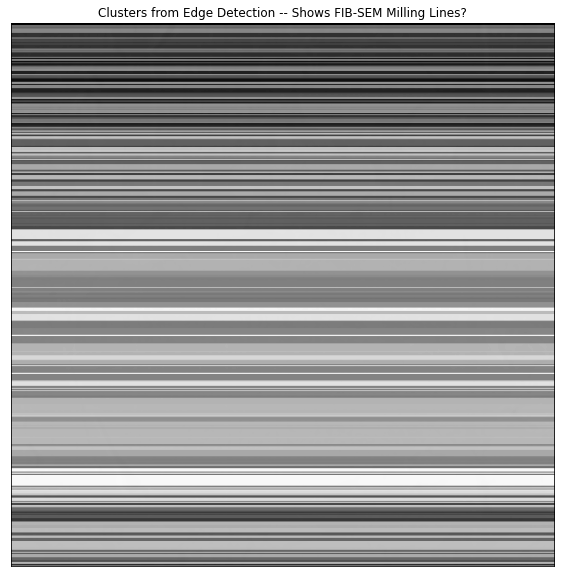

In [39]:
clusters = np.zeros(img.shape)
cluster_points = set()
for idx, piece in enumerate(pieces):
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    avg = np.average(img_tws[piece_points])
    std = np.std(img_tws[piece_points])
    clusters[piece_points] = img_gauss[piece_points] - avg # (img_gauss[piece_points] + np.average(img_gauss[piece_points]))/np.std(img_gauss[piece_points])
new_img = filters.gaussian(clusters)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clusters, cmap='gray')
ax.set_title("Clusters from Edge Detection -- Shows FIB-SEM Milling Lines?")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

In [40]:
plt.imsave("trial.bmp", new_img, cmap='gray')

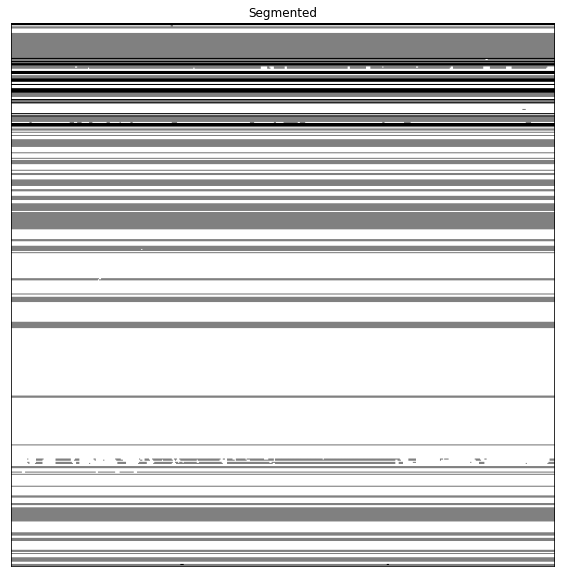

In [41]:
thresholds = filters.threshold_multiotsu(clusters, nbins=3)
img = np.digitize(clusters, bins=thresholds)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title("Segmented")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()